# Contraceptive Use in Indonesia: 1987 Study #

## Source: UCI Machine Learning Repository ##
### URL: [WebLink](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice)


Source:

** Origin: **
- This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey 

** Creator and Donor: **
- [Tjen-Sien Lim](limt@stat.wisc.edu) 

** Relevant Papers:**
- [Lim, T.-S., Loh, W.-Y. & Shih, Y.-S. (1999). A Comparison of Prediction Accuracy, Complexity, and Training Time of Thirty-three Old and New Classification Algorithms. Machine Learning](http://www.stat.wisc.edu/~loh/treeprogs/guide/mach1317.pdf)

In [1]:
data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data'

import pandas as pd
import numpy as np
import requests
import re

import matplotlib.pyplot as plt
import seaborn as sb
import bokeh as bk
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper, Slider
from bokeh.io import curdoc, show, output_notebook, push_notebook, output_file
from bokeh.layouts import widgetbox, column, row, gridplot
from bokeh.plotting import figure

%matplotlib inline
plt.style.use('bmh')

pink_green = 'PiYG'
paired_colors = 'Paired'


##for CatColorMapper, 
''' 
CatColMap = CategoricalColorMapper(factors =[], palette = [])
Hover = HoverTool(tooltips=[('string label','@column_name')])

plot.add_tools(Hover)
plot.circle(x,y,source=source,color={'field':[column_name],'transform':[CatColMap]})'''

##for gridplot,
'''
layout = gridplot(list of rows)
gridplot shares the toolbar for all plots
'''

##for callbacks,
'''
def callback(attr,old,new):
    [insert Slider function]
    
slider.on_change('value',callback)
'''

##for bokeh server,
'''
curdoc().add_root(layout)

in the shell:

bokeh serve --show myapplication.py
'''

'\ncurdoc().add_root(layout)\n\nin the shell:\n\nbokeh serve --show myapplication.py\n'

In [2]:
url = requests.get(data)

In [3]:
url.text[:100]

'24,2,3,3,1,1,2,3,0,1\n45,1,3,10,1,1,3,4,0,1\n43,2,3,7,1,1,3,4,0,1\n42,3,2,9,1,1,3,3,0,1\n36,3,3,8,1,1,3,'

In [4]:
rows = url.text.split(sep='\n')

In [5]:
rows[0]

'24,2,3,3,1,1,2,3,0,1'

In [6]:
rows_lists = [[l] for l in rows]

In [7]:
pattern = '\d+'

In [8]:
#rows_ints = [re.findall(pattern,l) for l in rows]
rows_ints = [list(map(int,re.findall(pattern,l))) for l in rows]

## Function thought: add option to import data as category or int

In [9]:
rows_ints[-1]
#need to filter out the last row, which is empty for some reason

[]

In [10]:
'''1. Wife's age                     (numerical)
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical)
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use 
                                                        2=Long-term
                                                        3=Short-term'''


columns = ['wife_age','wife_edu','husb_edu','num_child','wife_islam','wife_unemployed','husb_occupation','life_std','bad_media','contra_type']

In [11]:
df = pd.DataFrame.from_records(rows_ints[:-1],columns=columns)

In [12]:
df.tail()

,wife_age,wife_edu,husb_edu,num_child,wife_islam,wife_unemployed,husb_occupation,life_std,bad_media,contra_type
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3
1472,17,3,3,1,1,1,2,4,0,3


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
wife_age           1473 non-null int64
wife_edu           1473 non-null int64
husb_edu           1473 non-null int64
num_child          1473 non-null int64
wife_islam         1473 non-null int64
wife_unemployed    1473 non-null int64
husb_occupation    1473 non-null int64
life_std           1473 non-null int64
bad_media          1473 non-null int64
contra_type        1473 non-null int64
dtypes: int64(10)
memory usage: 115.2 KB


[]

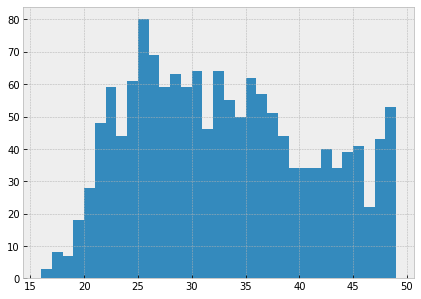

In [14]:
age_range = df.wife_age.max() - df.wife_age.min()

df.wife_age.hist(bins=age_range,figsize=(7,5))
plt.plot()

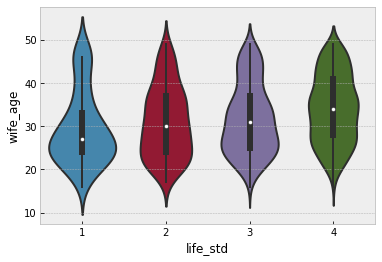

In [15]:
sb.violinplot(x='life_std',y='wife_age',data=df)

In [16]:
for c in list(df.columns)[1:]:
    print('--{} variables:\n'.format(c))
    print(df[c].value_counts(),'\n')

--wife_edu variables:

4    577
3    410
2    334
1    152
Name: wife_edu, dtype: int64 

--husb_edu variables:

4    899
3    352
2    178
1     44
Name: husb_edu, dtype: int64 

--num_child variables:

2     276
1     276
3     259
4     197
5     135
0      97
6      92
7      49
8      47
9      16
11     11
10     11
12      4
13      2
16      1
Name: num_child, dtype: int64 

--wife_islam variables:

1    1253
0     220
Name: wife_islam, dtype: int64 

--wife_unemployed variables:

1    1104
0     369
Name: wife_unemployed, dtype: int64 

--husb_occupation variables:

3    585
1    436
2    425
4     27
Name: husb_occupation, dtype: int64 

--life_std variables:

4    684
3    431
2    229
1    129
Name: life_std, dtype: int64 

--bad_media variables:

0    1364
1     109
Name: bad_media, dtype: int64 

--contra_type variables:

1    629
3    511
2    333
Name: contra_type, dtype: int64 



#### Binning the # children and age to prep for one-hot encoding

In [17]:
df['num_children'] = pd.cut(df['num_child'],[-1,1,3,6,max(df['num_child'])],labels=['[0-1]','(1-3]','(3-6]','(6-{}]'.format(max(df['num_child']))])

In [18]:
df['num_children'].value_counts()

(1-3]     535
(3-6]     424
[0-1]     373
(6-16]    141
Name: num_children, dtype: int64

In [19]:
df['wife_range'] = pd.cut(df['wife_age'].astype('int64'),bins=[0,24,30,37,43,max(df['wife_age'])],labels=['[18-24]','(24-29]','(29-37]','(37-43]','(43-{}]'.format(max(df['wife_age']))])

In [20]:
df['wife_range'].value_counts()

(24-29]    394
(29-37]    385
[18-24]    276
(37-43]    220
(43-49]    198
Name: wife_range, dtype: int64

In [21]:
df_2 = pd.crosstab(df['wife_range'],df['num_children'],normalize='index')
df_2

num_children,[0-1],(1-3],(3-6],(6-16]
wife_range,,,,
[18-24],0.601449,0.355072,0.043478,0.000000
(24-29],0.314721,0.467005,0.200508,0.017766
(29-37],0.088312,0.394805,0.428571,0.088312
(37-43],0.100000,0.286364,0.422727,0.190909
(43-49],0.136364,0.191919,0.378788,0.292929


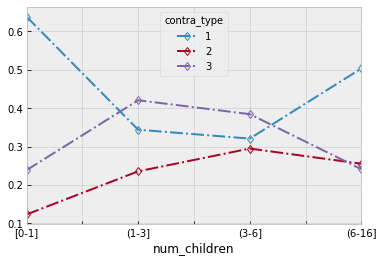

In [22]:
df_3 = pd.crosstab(df['num_children'],df['contra_type'],normalize='index')
df_3.plot(marker='d',markerfacecolor='none',linestyle='-.')

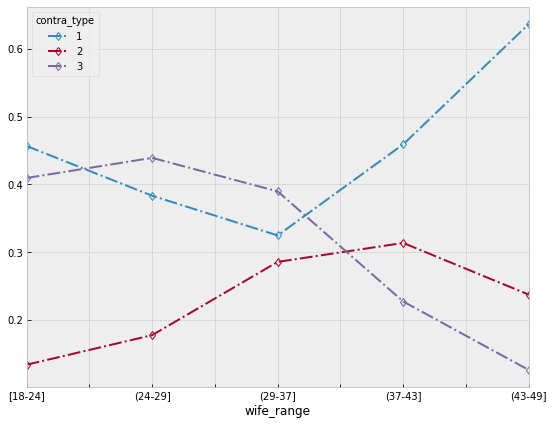

In [23]:
df_4 = pd.crosstab(df['wife_range'],df['contra_type'],normalize='index')
df_4.plot(marker='d',markerfacecolor='none',linestyle='-.',figsize=(9,7))

- Normalized the frequency counts due to the discrepancy in population. When looking at raw totals, it appears as though contraceptive type 1 decreases with age, but the proportion of women using no contraception actually appears to increase after around age 37.

In [24]:
df.drop(['wife_age','num_child'],axis=1,inplace=True)

In [25]:
for c in ['wife_edu','husb_edu','husb_occupation','life_std','contra_type']:
    df[c] = df[c].astype('category')

In [26]:
df_dummies = pd.get_dummies(df)
df_dummies.head()

,wife_islam,wife_unemployed,bad_media,wife_edu_1,wife_edu_2,wife_edu_3,wife_edu_4,husb_edu_1,husb_edu_2,husb_edu_3,...,contra_type_3,num_children_[0-1],num_children_(1-3],num_children_(3-6],num_children_(6-16],wife_range_[18-24],wife_range_(24-29],wife_range_(29-37],wife_range_(37-43],wife_range_(43-49]
0,1,1,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
1,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,1,1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,1,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [27]:
def sigmoid(array):
    sig = 1 + (1 - np.exp(-array))
    return sig

In [28]:
def reorder_df(df,list_of_targets=None):
    #quick function to change column order in dataframe
    
    if list_of_targets is None:
        list_of_targets = ['contra_type_1','contra_type_2','contra_type_3']

    columns = list(df.columns)
    
    for i in list_of_targets:
        columns.pop(columns.index(i))
        columns.append(i)

    df = df.loc[:,columns]
    return df


In [29]:
df_dummies = reorder_df(df_dummies)

In [30]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 31 columns):
wife_islam             1473 non-null int64
wife_unemployed        1473 non-null int64
bad_media              1473 non-null int64
wife_edu_1             1473 non-null uint8
wife_edu_2             1473 non-null uint8
wife_edu_3             1473 non-null uint8
wife_edu_4             1473 non-null uint8
husb_edu_1             1473 non-null uint8
husb_edu_2             1473 non-null uint8
husb_edu_3             1473 non-null uint8
husb_edu_4             1473 non-null uint8
husb_occupation_1      1473 non-null uint8
husb_occupation_2      1473 non-null uint8
husb_occupation_3      1473 non-null uint8
husb_occupation_4      1473 non-null uint8
life_std_1             1473 non-null uint8
life_std_2             1473 non-null uint8
life_std_3             1473 non-null uint8
life_std_4             1473 non-null uint8
num_children_[0-1]     1473 non-null uint8
num_children_(1-3]     1473 non-n

In [31]:
df_features = df_dummies.iloc[:,:-3]
df_targets = df_dummies.iloc[:,-3:]

In [32]:
features_matrix = df_features.as_matrix()
targets_matrix = df_targets.as_matrix()

In [33]:
weights = np.zeros(features_matrix.shape[1])

In [34]:
predictions = sigmoid(np.dot(features_matrix,weights))

In [35]:
sum(np.round(predictions)==targets_matrix[:,0])/len(targets_matrix[:,0])

0.4270196877121521

In [36]:
predictions

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [37]:
weights_gradient = np.dot(features_matrix.T,(predictions-targets_matrix[:,0]))
weights_gradient

array([ 699.,  645.,   35.,   49.,  158.,  235.,  402.,   13.,   79.,
        191.,  561.,  278.,  225.,  327.,   14.,   49.,  112.,  247.,
        436.,  135.,  351.,  288.,   70.,  150.,  243.,  260.,  119.,   72.])

In [38]:
weights_gradient = weights_gradient / features_matrix.shape[0]
weights_gradient

array([ 0.47454175,  0.43788187,  0.02376103,  0.03326544,  0.10726409,
        0.15953836,  0.27291242,  0.00882553,  0.05363204,  0.12966735,
        0.3808554 ,  0.18873048,  0.15274949,  0.22199593,  0.00950441,
        0.03326544,  0.0760353 ,  0.167685  ,  0.29599457,  0.09164969,
        0.23828921,  0.19551935,  0.04752206,  0.10183299,  0.16496945,
        0.17651052,  0.08078751,  0.04887984])

In [39]:
weights = weights - (weights_gradient*0.05)
weights

array([-0.02372709, -0.02189409, -0.00118805, -0.00166327, -0.0053632 ,
       -0.00797692, -0.01364562, -0.00044128, -0.0026816 , -0.00648337,
       -0.01904277, -0.00943652, -0.00763747, -0.0110998 , -0.00047522,
       -0.00166327, -0.00380177, -0.00838425, -0.01479973, -0.00458248,
       -0.01191446, -0.00977597, -0.0023761 , -0.00509165, -0.00824847,
       -0.00882553, -0.00403938, -0.00244399])

In [40]:
gradient_df = pd.DataFrame()

In [41]:
def log_loss(predictions,actual,eps=1e-15):
    '''take an array of prediction probabilities (clipped to avoid undefined values) and measures accuracy while
    also factoring for confidence'''
    #assert (max(predictions)<=1 and min(predictions)>=0), 'Please make sure to use predict_proba'
    
    preds_clipped = np.clip(predictions,eps,1-eps)
    
    loss = -1 * np.mean((actual * np.log(preds_clipped)) + ((1-actual) * np.log(1-preds_clipped)))
    
    return loss

In [42]:
from sklearn.metrics import accuracy_score, roc_auc_score

## Testing Gradient Descent ##
### Target Variable: Contraceptive Type 1 (No Contraceptive)

- Keep in mind, this is not a final prediction
- No train/test split, just to peek at which factors have greatest influence on classification

In [43]:
weights = np.zeros(features_matrix.shape[1])
targets = targets_matrix[:,0]

row_list = []

for i in range(1000):
    prediction_proba = sigmoid(np.dot(features_matrix,weights))
    
    weights_gradient = np.dot(features_matrix.T,(prediction_proba-targets)) / features_matrix.shape[0]
    
    weights = weights - (weights_gradient*0.1)
    
    predictions = np.round(prediction_proba)
    
    row_list.append([*weights,roc_auc_score(targets,prediction_proba),log_loss(prediction_proba,targets),accuracy_score(targets,predictions)])
    
    if i % 100 == 0:
        print(round(sum(predictions==targets)/len(targets_matrix[:,0]),5))
        
    if i > 50:
        if abs((row_list[i][-3] - row_list[i-50][-3]) / row_list[i][-3]) < 0.001:
            break
        
gradient_df = pd.DataFrame(row_list)
    
    

0.42702
0.70604
0.70876


In [44]:
columns_list = list(df_features.columns)
columns_list.extend(('auc_score','log_loss','accuracy_score'))

In [45]:
top_auc_score = gradient_df.loc[:,28].idxmax(axis=1)

In [46]:
best_weights_for_loss= [(x,y) for x,y in zip(gradient_df.iloc[top_auc_score,].values,columns_list)]
best_weights_for_loss.sort(key = lambda x: x[0],reverse=True)

### Sanity Checks###

** Positive contributing factors to non-use of contraception: **

In [47]:
best_weights_for_loss[3:8]

[(0.12339809841809324, 'num_children_[0-1]'),
 (0.092059770648329001, 'wife_range_(43-49]'),
 (0.06021613569202415, 'bad_media'),
 (0.025141885917497882, 'wife_edu_1'),
 (0.017340525099032375, 'wife_islam')]

** Negative contributing factors to non-use of contraception: **

In [48]:
best_weights_for_loss[-5:]

[(-0.12172564522878283, 'wife_range_(24-29]'),
 (-0.12868726861442867, 'num_children_(6-16]'),
 (-0.14871104445635577, 'wife_range_[18-24]'),
 (-0.15989638142582693, 'num_children_(3-6]'),
 (-0.17816954618826547, 'wife_edu_4')]

In [49]:
from sklearn.naive_bayes import BernoulliNB

In [50]:
bern = BernoulliNB(alpha=0.1)

In [51]:
bern.fit(features_matrix,targets_matrix[:,0])

BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)

In [52]:
sum(bern.predict(features_matrix) == targets_matrix[:,0]) / len(targets_matrix[:,0])

0.65241004752206377

- Is my homemade function/ for-loop outperforming out of the box Bernoulli NB??